# Bayesian AB Testing - Part II - Revenue

### Series Structure
This post is the 2nd part of a series of blog posts on applying Bayesian AB Testing methods to real life product scenarios. It uses some of the concepts discussed in the [1st part of the series](https://towardsdatascience.com/bayesian-ab-testing-part-i-conversions-ac2635f878ec).

1. [Modelling and analysis of conversion based test metrics (rate metrics)](https://towardsdatascience.com/bayesian-ab-testing-part-i-conversions-ac2635f878ec)
2. Modelling and analysis of revenue based test metrics (continuous metrics)
3. Calculating test duration
4. Choosing an appropriate prior
5. Running tests with multiple variants

### Experiment Context
Let's assume we've recently made UX changes to a store feature in our app. We believe these changes make it easier for our users to make bigger in-app purchases and we want to AB test this before releasing to our wider user base. We hypothesise that the changes we've made will result in a significantly higher Average Revenue per User.

We model the Revenue generated by each user as a random variable $R = X*Y$, where:
- $X$ is a Bernoulli random variable which refers to whether the user made a purchase, with conversion probability $\lambda$
    - $X \sim Ber(\lambda)$
- $Y$ is an Exponential random variable which refers to the size of the purchase if it is made, with rate parameter $\theta$
    - $Y \sim Exp(\theta)$

Under this model, we have that the average revenue per sale is given by $1/\theta$ and the average revenue per user is given by $\lambda/\theta$. 

Our first step in this analysis is to look at past data to choose appropriate pior distributions for the key parameters $\lambda$ and $\theta$ of this model.

Following this, we set a loss threshold - the largest expected loss we're willing to accept in the scenario where we mistakenly roll out the wrong variant. As with any statistical modelling, bayesian experimentation methods are built on approximations of real world data. As such there is always a chance that we draw the wrong conclusions from the test. This loss threshold allows us to say that even if we did draw the wrong conclusions, we can be confident that the average revenue per user wouldn't drop more than this threshold.

Finally, we draw samples in the form of a randomised experiment and use these to update the distributions, and our beliefs, about $\lambda$ and $\theta$ under the control and treatment versions of the store. We can then use these posterior distributions to calculate the probabilities and expected loss that we're interested in.

In order to choose prior distributions for our parameters, let us first look at some past purchase data that we've recently gathered. I've generated a sample prior data set which we can use for this exercise.


In [5]:
import pandas as pd
import numpy as np

prior_data = pd.read_csv('prior_data.csv')

print(prior_data.head())
print(prior_data.shape)

                             userId  converted  revenue
0  54afb186003b471a9c0e760f13d070e9          0     0.00
1  573caa3b69c341969525d96574645311          0     0.00
2  6b5d6f1d809944e784660a5d184d4a57          1     0.44
3  7f2f0e45b73d4318ac314c28b0df1411          0     0.00
4  bf560f6acfd5452a95f65244ca7342b8          0     0.00
(5268, 3)


Since this data set is artificially generated, it's already in the ideal format for this exercise. In the real world, it's likely that we'd need to perform some ETL operations in order to get the data in this format. However this is outside the scope of this post.

We see that we have a sample size of 5268 users, and for each user we can see whether they made a purchase or not. For those users that did make a purchase, we can also see the size of purchase. We can go ahead and work out the prior conversion rate, average revenue per sale, rate parameter for the revenue per sale and average revenue per user.

In [19]:
conversion_rate = prior_data['converted'].sum()/prior_data.shape[0]
converted = prior_data[prior_data['converted'] == 1]
avg_purchase = converted['revenue'].mean()
print(f'Prior Conversion Rate is {round(conversion_rate, 3)}. Average Revenue per Sale is {round(avg_purchase, 3)}.')
print(f'Rate Parameter for Revenue per Sale is {round(1/avg_purchase, 3)}. Average Revenue per User is {round(conversion_rate*avg_purchase, 3)}.')

Prior Conversion Rate is 0.317. Average Revenue per Sale is 0.504.
Rate Parameter for Revenue per Sale is 1.983. Average Revenue per User is 0.16.


### Choosing a Prior Distribution
Using the information above, we can choose prior distributions for $\lambda$ and $\theta$. Using the same logic as [the previous post](https://towardsdatascience.com/bayesian-ab-testing-part-i-conversions-ac2635f878ec), we can choose a prior of $Beta(7, 15)$ for our conversion probability $\lambda$. In summary, we choose to use the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) because it's a flexible distribution over $[0,1]$ and a good [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior).

For $\theta$, the rate parameter for revenue per sale, we will use a [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) since it's a flexible distribution over $[0,\infty)$ and is also a good conjugate prior. It will make our calculations easier when we work out posteriors with experiment data.

We can choose a very weak prior distribution $Gamma(0.1,0.1)$. {1}

### Setting a loss threshold
Now that we've chosen our prior, we need to choose our $\epsilon$ which is the highest expected loss we're willing to accept in the case where we mistakenly choose the wrong variant. Let us assume the store isn't our primary source of revenue but it's pretty important to us so we want to be somewhat conservative with this $\epsilon$. We can set $\epsilon = 0.005$.

We have prior distributions and a threshold for our expected loss, so we can start running our experiment and gathering data from it.

### Experiment Results
Let's assume that we've left our experiment running for a couple of weeks and want to check whether we can draw any conclusions from it. In order to do this we need to use our experiment data to calculate our posterior distributions, which we can then use to calculate the probability of each variant being better, and also the expected loss of wrongly choosing each variant.

For the purposes of this exercise, I've generated a sample experiment data set. Let's start off by exploring it.

In [3]:
experiment_data = pd.read_csv('experiment_data.csv')

print(experiment_data.head())
print(experiment_data.shape)

                             userId      group  converted  revenue
0  50b13830678944738ba47b38623564b4    control          0     0.00
1  5d48ad938b0a43d490308b15490c29b3  treatment          1     0.31
2  608aa267fa934cf8a71fb09ffb4588ee    control          0     0.00
3  aa8b2feb848441629e9ae133b8e69cc2  treatment          0     0.00
4  f1ffc92f0edd4a52ab5295657257b7cd    control          0     0.00
(5101, 4)


We see that the data set is similar to the prior data set with an extra column for specifying which the group the user was allocated to and therefore which variant they saw. Once again it's worth noting that since this data set is artificially generated, it's already in the ideal format for this exercise wihtout the need for additional ETL operations.

We can now go ahead and aggregate the data.

In [25]:
results = experiment_data.groupby('group').agg({'userId': pd.Series.nunique, 'converted': sum, 'revenue': sum})
results.rename({'userId': 'sampleSize'}, axis=1, inplace=True)
results['conversionRate'] = results['converted']/results['sampleSize']
results['revenuePerSale'] = results['revenue']/results['converted']
print(results)

           sampleSize  converted  revenue  conversionRate  revenuePerSale
group                                                                    
control          2743        895   447.02        0.326285        0.499464
treatment        2358        772   598.96        0.327396        0.775855


Upon inspection it seems that both groups have similar conversion rates but treatment has a better revenue per sale. However, in order to update our beliefs about $\lambda$ and $\theta$ of the two variants, we need to perform further calculations.

Using the calculations outlined in [the previous post](https://towardsdatascience.com/bayesian-ab-testing-part-i-conversions-ac2635f878ec), we can calculate posterior distributions of $\lambda$ for the two variants.

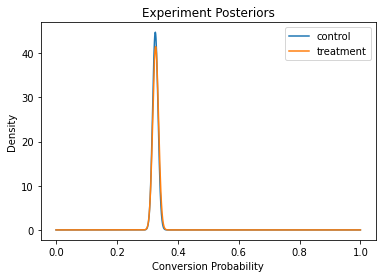

In [20]:
from scipy.stats import beta, gamma
import seaborn as sns
import matplotlib.pyplot as plt

control_cr = beta(7 + results.loc['control', 'converted'], 15 + results.loc['control', 'sampleSize'] - results.loc['control', 'converted'])
treatment_cr = beta(7 + results.loc['treatment', 'converted'], 15 + results.loc['treatment', 'sampleSize'] - results.loc['treatment', 'converted'])

fig, ax = plt.subplots()

x = np.linspace(0,1,1000)

ax.plot(x, control_cr.pdf(x), label='control')
ax.plot(x, treatment_cr.pdf(x), label='treatment')
ax.set_xlabel('Conversion Probability')
ax.set_ylabel('Density')
ax.set_title('Experiment Posteriors')
ax.legend()

The posterior distributions of $\lambda_c$ and $\lambda_t$ are almost identical. By inspection we can see that the treatment hasn't had a big effect the conversion probability.

Let's go ahead and see how it has affected the rate parameter for revenue. We will be using the following result {2} to calculate $\theta_c$ and $\theta_t$:

Suppose the prior

$\theta \sim Gamma(k, \Theta)$

Suppose a variant was displayed to $n$ visitors. $c$ converted with an average revenue per sale of $s$. Then, the posterior distribution is given by

$\theta|c,s \sim Gamma(k + c, \frac{\Theta}{1 + \Theta c s})$

(If you're curious about the maths behind this result it is proven [here](https://cdn2.hubspot.net/hubfs/310840/VWO_SmartStats_technical_whitepaper.pdf).)

Let's go ahead and calculate our posteriors $\theta_c$ and $\theta_t$.

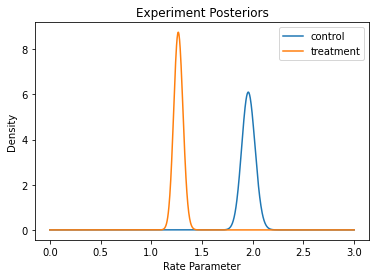

In [21]:
control_rr = gamma(a=(0.1 + results.loc['control', 'converted']), scale=(0.1/(1 + (0.1)*results.loc['control', 'converted']*results.loc['control', 'revenuePerSale'])))
treatment_rr = gamma(a=(0.1 + results.loc['treatment', 'converted']), scale=(0.1/(1 + (0.1)*results.loc['treatment', 'converted']*results.loc['treatment', 'revenuePerSale'])))

fig, ax = plt.subplots()

x = np.linspace(0,3,1000)

ax.plot(x, control_rr.pdf(x), label='control')
ax.plot(x, treatment_rr.pdf(x), label='treatment')
ax.set_xlabel('Rate Parameter')
ax.set_ylabel('Density')
ax.set_title('Experiment Posteriors')
ax.legend()

The posterior distributions don't overlap at all, so we can be fairly certain that one of the variants is better than the other. The treatment rate parameter is lower than the control rate parameter so is better since it will result in a higher average revenue per sale. In order to see this more clearly, let's plot the distributions of average revenue per sale under these posteriors.

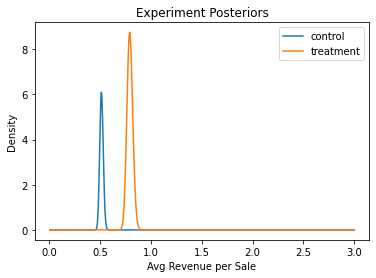

In [14]:
fig, ax = plt.subplots()

x = np.linspace(0,3,1000)
z = [1/i for i in x]

ax.plot(x, control_rr.pdf(z), label='control')
ax.plot(x, treatment_rr.pdf(z), label='treatment')
ax.set_xlabel('Avg Revenue per Sale')
ax.set_ylabel('Density')
ax.set_title('Experiment Posteriors')
ax.legend()

We can clearly see that the average revenue per sale is higher for treatment than for control.

So both variants have a similar conversion rate but treatment has a better average revenue per sale, so it must also have a better average revenue per user. Let's plot the posterior of average revenue per user to confirm this. We can run some simulations to help us with this.

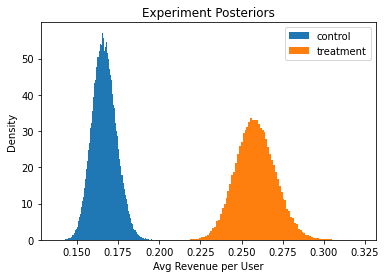

In [24]:
control_conversion_simulation = np.random.beta(7 + results.loc['control', 'converted'], 15 + results.loc['control', 'sampleSize'] - results.loc['control', 'converted'], size=100000)
treatment_conversion_simulation = np.random.beta(7 + results.loc['treatment', 'converted'], 15 + results.loc['treatment', 'sampleSize'] - results.loc['treatment', 'converted'], size=100000)

control_revenue_simulation = np.random.gamma(shape=(0.1 + results.loc['control', 'converted']), scale=(0.1/(1 + (0.1)*results.loc['control', 'converted']*results.loc['control', 'revenuePerSale'])), size=100000)
treatment_revenue_simulation = np.random.gamma(shape=(0.1 + results.loc['treatment', 'converted']), scale=(0.1/(1 + (0.1)*results.loc['treatment', 'converted']*results.loc['treatment', 'revenuePerSale'])), size=100000)

control_avg_purchase = [i/j for i,j in zip(control_conversion_simulation, control_revenue_simulation)]
treatment_avg_purchase = [i/j for i,j in zip(treatment_conversion_simulation, treatment_revenue_simulation)]

fig, ax = plt.subplots()

x = np.linspace(0,1,1000)

ax.hist(control_avg_purchase, density=True, label='control', histtype='stepfilled', bins=100)
ax.hist(treatment_avg_purchase, density=True, label='treatment', histtype='stepfilled', bins=100)
ax.set_xlabel('Avg Revenue per User')
ax.set_ylabel('Density')
ax.set_title('Experiment Posteriors')
ax.legend()

Treatment has clearly resulted in a better average revenue per user than control. By inspection of these posteriors we can be pretty confident that treatment is better. However, in order to quantify this, we need to calculate $p(\lambda_t/\theta_t \geq \lambda_c/\theta_c)$ and $E[L](t)$, the expected loss of wrongly choosing treatment.

In [17]:
treatment_won = [i <= j for i,j in zip(control_avg_purchase, treatment_avg_purchase)]

chance_to_beat_ctrl = np.mean(treatment_won)
print(f'Chance of beating control: {round(chance_to_beat_ctrl, 3)}.')

Chance of beating control: 1.0.


From the simulations we see that $p(\lambda_t/\theta_t \geq \lambda_c/\theta_c) = 1$ so treatment has a 100% chance of being better than control.

Now that we've calculated the probability of treatment being better, we need to calculate $E[L](t)$. The loss function of each variant is given by 

$L(\lambda_c, \lambda_t,t) = max(\frac{\lambda_c}
{\theta_c} - \frac{\lambda_t}{\theta_t}, 0) \\ L(\lambda_c, \lambda_t,c) = max(\frac{\lambda_t}{\theta_t} - \frac{\lambda_c}{\theta_c}, 0)$

We use this to calculate the expected loss

In [18]:
def calculate_expected_loss(control_avg_purchase, treatment_avg_purchase, treatment_won):
    loss_control = [max(j - i, 0) for i,j in zip(control_avg_purchase, treatment_avg_purchase)]
    loss_treatment = [max(i - j, 0) for i,j in zip(control_avg_purchase, treatment_avg_purchase)]

    all_loss_control = [int(i)*j for i,j in zip(treatment_won, loss_control)]
    all_loss_treatment = [(1 - int(i))*j for i,j in zip(treatment_won, loss_treatment)]

    expected_loss_control = np.mean(all_loss_control)
    expected_loss_treatment = np.mean(all_loss_treatment)
    return expected_loss_control, expected_loss_treatment

expected_loss_control, expected_loss_treatment = calculate_expected_loss(control_avg_purchase, treatment_avg_purchase, treatment_won)
print(f'Expected loss of choosing control: {round(expected_loss_control, 3)}. Expected loss of choosing treatment: {round(expected_loss_treatment, 3)}')

Expected loss of choosing control: 0.092. Expected loss of choosing treatment: 0.0


From running simulations we see that:

$E[L](t) = 0 \lt 0.005 = \epsilon$

Since the expected loss of one of the variants is below the threshold that we set at the start of the test, the test has reached significance. We can conclude with high confidence that the treatment is better, and that the expected cost of mistakenly choosing treatment would not be greater than what we're comfortable with. So we can strongly recommend that the treatment variant of the upsell screen should be rolled out to the rest of our user base.


### References

1. [Optimizing Revenue with Bayesian A/B testing
](https://medium.com/ni-tech-talk/optimizing-revenue-with-bayesian-a-b-testing-5068e8ac41ea) by Omri Fima
2. [VWO Whitepaper](https://cdn2.hubspot.net/hubfs/310840/VWO_SmartStats_technical_whitepaper.pdf) by C.Stucchio